In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.decomposition import PCA

In [18]:
# 加载文件
def load_data(file_path):
    data = pd.read_csv(file_path)
    data = data.iloc[:, :-1]  # 删除最后一列
    features = data.iloc[:, :-1]  # 提取特征
    labels = data.iloc[:, -1]    # 提取标签（倒数第二列为角度）
    return features, labels

# 对特征进行标准化处理
def standardize_data(features):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled

In [20]:
#线性回归
def train_linear_regression(features, labels):
    model = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, features, labels, cv=kf, scoring='r2')
    print(f"Cross-Validation R2 Scores: {scores}")
    print(f"Average R2 Score: {np.mean(scores):.4f}")
    model.fit(features, labels)
    return model

In [22]:
# 学习曲线绘制
def plot_learning_curve(model, features, labels):
    train_sizes, train_scores, test_scores = learning_curve(
        model, features, labels, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Score")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [24]:
#模型评估
def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    mse = mean_squared_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    return predictions

In [26]:
#混淆矩阵以及各类分数
def plot_confusion_matrix(labels, predictions):
    labels_discrete = np.round(labels / 5) * 5
    predictions_discrete = np.round(predictions / 5) * 5
    cm = confusion_matrix(labels_discrete, predictions_discrete)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Angle')
    plt.ylabel('True Angle')
    plt.colorbar()
    plt.show()

    accuracy = accuracy_score(labels_discrete, predictions_discrete)
    precision = precision_score(labels_discrete, predictions_discrete, average='weighted')
    recall = recall_score(labels_discrete, predictions_discrete, average='weighted')
    f1 = f1_score(labels_discrete, predictions_discrete, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [ ]:
# 训练集路径
train_file_path = '../csv/Cs137_Dataset_rebin/dataset_Cs137_rebin_17_380_acc_training_data.csv'
features_train, labels_train = load_data(train_file_path)
features_train_scaled = standardize_data(features_train)

# 测试集路径
test_file_path = '../csv/Cs137_Dataset_rebin/dataset_Cs137_rebin_17_380_acc_testing_data.csv'
features_test, labels_test = load_data(test_file_path)
features_test_scaled = standardize_data(features_test)


D:\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
D:\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Cross-Validation R2 Scores: [0.2327773  0.22119051 0.21652365 0.22231281 0.21216232]
Average R2 Score: 0.2210


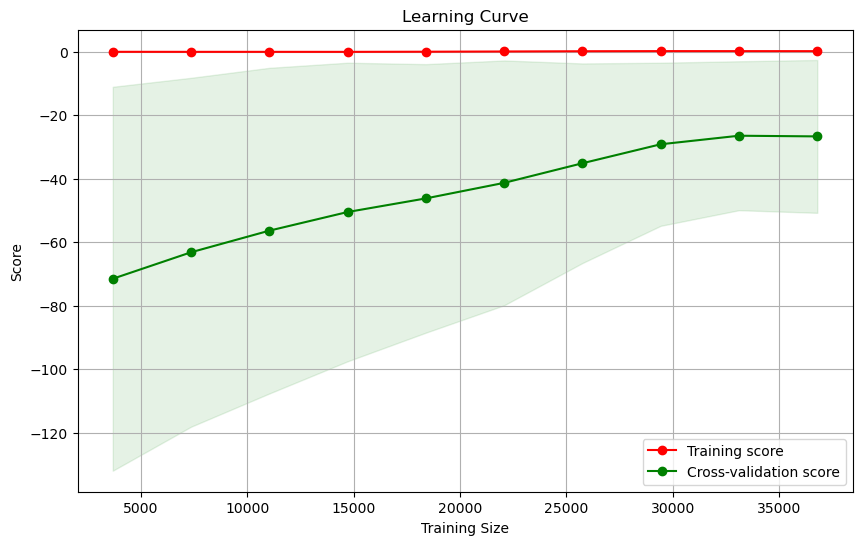

Mean Squared Error (MSE): 8212.7327
R-squared (R2) Score: 0.2257


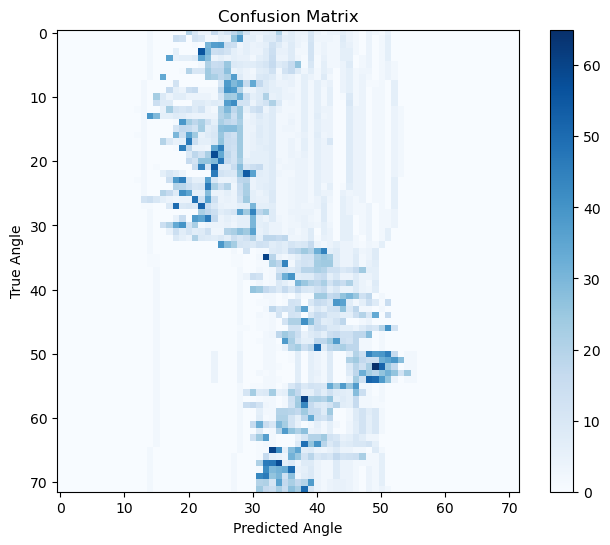

Accuracy: 0.0252
Precision: 0.0243
Recall: 0.0252
F1 Score: 0.0192


D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
# UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_train = umap_reducer.fit_transform(features_train_scaled)
embedding_test = umap_reducer.transform(features_test_scaled)

# 训练模型（使用UMAP降维后的特征）
model = train_linear_regression(embedding_train, labels_train)

# 学习曲线
plot_learning_curve(model, embedding_train, labels_train)

# 测试集评估（使用UMAP降维后的特征）
predictions = evaluate_model(model, embedding_test, labels_test)
plot_confusion_matrix(labels_test, predictions)

Cross-Validation R2 Scores: [0.66429715 0.66068868 0.65378641 0.65465814 0.65530179]
Average R2 Score: 0.6577


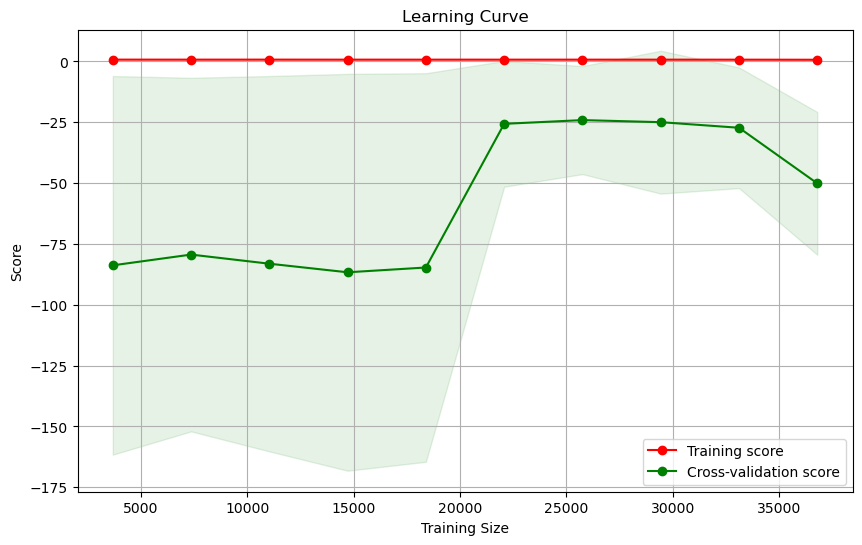

Mean Squared Error (MSE): 3602.7165
R-squared (R2) Score: 0.6603


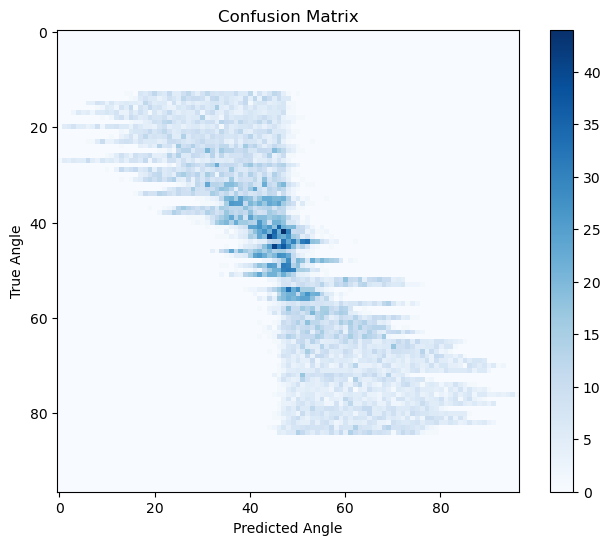

Accuracy: 0.0382
Precision: 0.0402
Recall: 0.0382
F1 Score: 0.0363


D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# PCA降维及可视化
pca = PCA(n_components=50)
pca_embedding_train = pca.fit_transform(features_train_scaled)
pca_embedding_test = pca.transform(features_test_scaled)

# 训练模型（使用PCA降维后的特征）
model = train_linear_regression(pca_embedding_train, labels_train)

# 学习曲线
plot_learning_curve(model, pca_embedding_train, labels_train)

# 测试集评估（使用PCA降维后的特征）
predictions = evaluate_model(model, pca_embedding_test, labels_test)
plot_confusion_matrix(labels_test, predictions)